<a href="https://colab.research.google.com/github/afirth03/IMLOAssessment/blob/main/IMLOExam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flowers 102 Dataset Classification

Pre-Processing

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation = 0.2, hue = 0.1),
    transforms.RandomAffine(degrees = 0, translate = (0.1,0.1), scale=(0.9, 1.1), shear = 10),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.1, scale = (0.02, 0.1), ratio=(0.8, 1.2)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

batch_size = 64

train_data = datasets.Flowers102(
    root="data",
    split="train",
    download=True,
    transform=transform_train
)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

test_data = datasets.Flowers102(
    root="data",
    split="test",
    download=True,
    transform=transform

)

testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=False, num_workers=0)

val_data = datasets.Flowers102(
    root="data",
    split="val",
    download=True,
    transform=transform
)

valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          shuffle=False, num_workers=0)

classes = {"0": "error", "21": "fire lily", "3": "canterbury bells", "45": "bolero deep blue", "1": "pink primrose", "34": "mexican aster", "27": "prince of wales feathers", "7": "moon orchid", "16": "globe-flower", "25": "grape hyacinth", "26": "corn poppy", "79": "toad lily", "39": "siam tulip", "24": "red ginger", "67": "spring crocus", "35": "alpine sea holly", "32": "garden phlox", "10": "globe thistle", "6": "tiger lily", "93": "ball moss", "33": "love in the mist", "9": "monkshood", "102": "blackberry lily", "14": "spear thistle", "19": "balloon flower", "100": "blanket flower", "13": "king protea", "49": "oxeye daisy", "15": "yellow iris", "61": "cautleya spicata", "31": "carnation", "64": "silverbush", "68": "bearded iris", "63": "black-eyed susan", "69": "windflower", "62": "japanese anemone", "20": "giant white arum lily", "38": "great masterwort", "4": "sweet pea", "86": "tree mallow", "101": "trumpet creeper", "42": "daffodil", "22": "pincushion flower", "2": "hard-leaved pocket orchid", "54": "sunflower", "66": "osteospermum", "70": "tree poppy", "85": "desert-rose", "99": "bromelia", "87": "magnolia", "5": "english marigold", "92": "bee balm", "28": "stemless gentian", "97": "mallow", "57": "gaura", "40": "lenten rose", "47": "marigold", "59": "orange dahlia", "48": "buttercup", "55": "pelargonium", "36": "ruby-lipped cattleya", "91": "hippeastrum", "29": "artichoke", "71": "gazania", "90": "canna lily", "18": "peruvian lily", "98": "mexican petunia", "8": "bird of paradise", "30": "sweet william", "17": "purple coneflower", "52": "wild pansy", "84": "columbine", "12": "colt's foot", "11": "snapdragon", "96": "camellia", "23": "fritillary", "50": "common dandelion", "44": "poinsettia", "53": "primula", "72": "azalea", "65": "californian poppy", "80": "anthurium", "76": "morning glory", "37": "cape flower", "56": "bishop of llandaff", "60": "pink-yellow dahlia", "82": "clematis", "58": "geranium", "75": "thorn apple", "41": "barbeton daisy", "95": "bougainvillea", "43": "sword lily", "83": "hibiscus", "78": "lotus lotus", "88": "cyclamen", "94": "foxglove", "81": "frangipani", "74": "rose", "89": "watercress", "73": "water lily", "46": "wallflower", "77": "passion flower", "51": "petunia"}

100%|██████████| 344862509/344862509 [00:17<00:00, 20107794.53it/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 1481731.60it/s]


100%|██████████| 14989/14989 [00:00<00:00, 23849932.72it/s]


##Matching the label to the flower name

In [2]:
def flower_name(label, classes):
    flower_name = {int(k): v for k, v in classes.items()}
    return flower_name.get(label, "Unknown")

# Display Processed images randomly

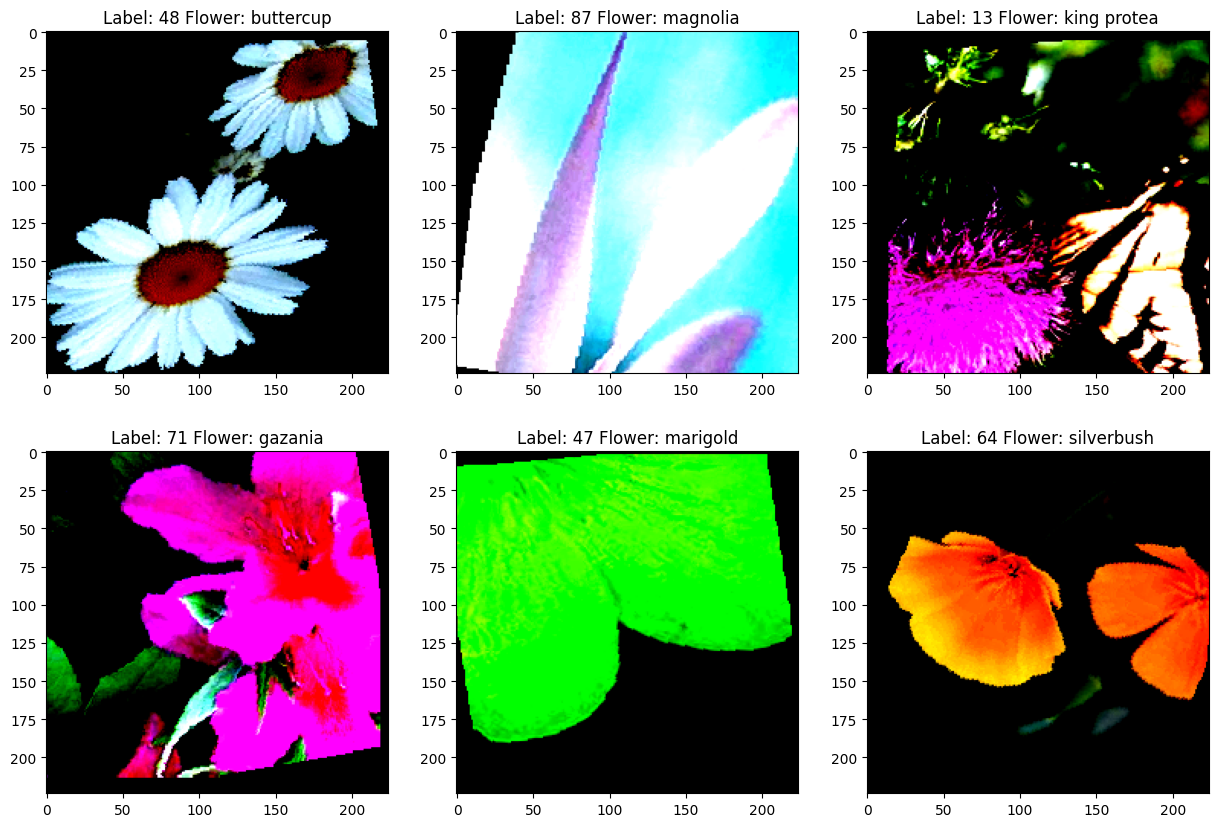

In [3]:
figure = plt.figure(figsize=(15, 10))
cols, rows = 3, 2

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(val_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    img = img.permute(1, 2, 0)
    ax = figure.add_subplot(rows, cols, i)
    ax.set_title(f'Label: {label} Flower: {flower_name(label, classes)}')
    ax.axis("on")
    ax.imshow(img.squeeze(), cmap="Accent")
plt.show()

# Creating Neural Network

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.features = nn.Sequential( #Sequential for modularity

            nn.Conv2d(3, 64, 3, stride = 2, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, stride = 2, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(5, 2),

            nn.Conv2d(128, 256, 3, stride = 1, padding = 1), #Reduced stride from 2 to 1 to capture detailed info from images
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 512, 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),

            nn.AdaptiveAvgPool2d((14, 14)) #Makes the input fit a 512 * 14 * 14 input

        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 14 * 14, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5), #Dropout data to reduce overfitting
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.25),
            nn.Linear(512, 102)  #Output classes in Flowers 102
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  #Flatten the output for the fully connected layer
        x = self.classifier(x)
        return x

cnn = CNN()
print(cnn)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=

##Training and testing the CNN

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9,weight_decay=0.0001)
cnn.train()

for epoch in range(200):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0], data[1]

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 8 == 7:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 8:.3f}')
            running_loss = 0.0

print('Finished Training')

In [ ]:
cnn.eval()
running_loss = 0.0
running_accuracy = 0.0

for i, data in enumerate(valloader):
    inputs, labels = data[0].to(device), data[1].to(device)

    with torch.no_grad():
        outputs = cnn(inputs)
        correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
        running_accuracy += correct / batch_size
        loss = criterion(outputs, labels)
        running_loss += loss.item()

avg_loss_across_batches = running_loss / len(valloader)
avg_acc_across_batches = (running_accuracy / len(valloader)) * 100

print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss_across_batches,
                                                            avg_acc_across_batches))

In [ ]:
cnn.eval()

with torch.no_grad():
    correct = 0
    total = 0

    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)

        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

##Download the graph

In [ ]:
%pip install torchviz

In [9]:
from torchviz import make_dot

cnn.to(device)

x = torch.randn(2, 3, 224, 224).to(device)

dot = make_dot(cnn(x), params=dict(cnn.named_parameters()))
dot.render('cnn_graph', format='pdf')

'cnn_graph.pdf'

In [11]:
from google.colab import files

files.download('cnn_graph.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>